<a href="https://colab.research.google.com/github/mhlr/cartographer/blob/main/notebooks/demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q pyjanitor
!pip install -q dask[dataframe,bag,distributed]

     |████████████████████████████████| 81kB 2.6MB/s 
     |████████████████████████████████| 102kB 6.0MB/s 
     |████████████████████████████████| 184kB 40.8MB/s 
     |████████████████████████████████| 348kB 37.5MB/s 
     |████████████████████████████████| 204.2MB 19kB/s 
     |████████████████████████████████| 1.1MB 45.2MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 102kB 12.9MB/s 
     |████████████████████████████████| 235kB 63.5MB/s 
     |████████████████████████████████| 276kB 54.2MB/s 
     |████████████████████████████████| 4.9MB 57.4MB/s 
     |████████████████████████████████| 102kB 10.2MB/s 
     |████████████████████████████████| 81kB 11.7MB/s 
     |████████████████████████████████| 204kB 79.2MB/s 
     |████████████████████████████████| 747kB 73.2MB/s 
     |████████████████████████████████| 727kB 52.9MB/s 
     |████████████████████████████████

In [2]:
%pylab inline
from builtins import *
from toolz.curried import *
import pandas as pd
import janitor
from dask import dataframe as ddf
import networkx as nx
import gensim
from gensim import summarization as summ
import requests

Populating the interactive namespace from numpy and matplotlib


In [3]:
r = requests.get('http://www.gutenberg.org/cache/epub/2009/pg2009.txt')
print(r.encoding)

utf-8


In [4]:
display(pd.Series(r.text.split('ORIGIN OF SPECIES')).str.len())

0        569
1         53
2      34958
3    1237831
4      18989
dtype: int64

In [5]:
doc = r.text.split('ORIGIN OF SPECIES')[3].replace('\r\n', '\n')
display(doc)

'.\n\n\n\n\nINTRODUCTION.\n\nWhen on board H.M.S. Beagle, as naturalist, I was much struck with\ncertain facts in the distribution of the organic beings inhabiting South\nAmerica, and in the geological relations of the present to the past\ninhabitants of that continent. These facts, as will be seen in the\nlatter chapters of this volume, seemed to throw some light on the origin\nof species--that mystery of mysteries, as it has been called by one\nof our greatest philosophers. On my return home, it occurred to me,\nin 1837, that something might perhaps be made out on this question by\npatiently accumulating and reflecting on all sorts of facts which could\npossibly have any bearing on it. After five years\' work I allowed myself\nto speculate on the subject, and drew up some short notes; these I\nenlarged in 1844 into a sketch of the conclusions, which then seemed to\nme probable: from that period to the present day I have steadily pursued\nthe same object. I hope that I may be excused 

In [6]:
pars = pd.Series(doc.split('\n\n')).str.replace('\n', ' ')

In [7]:
pars.str.len().apply(lambda x:log2(x+1)).astype(int).value_counts()

10    436
5     364
4     278
9     234
6     183
11    120
7     112
8      95
3      87
0      19
12      2
2       2
1       1
dtype: int64

In [8]:
%time kwds = summ.keywords(doc, scores=True, lemmatize=True, words=200)
len(kwds)

CPU times: user 32.8 s, sys: 3.69 s, total: 36.4 s
Wall time: 34.8 s


198

(-0.5, 2999.5, 1299.5, -0.5)

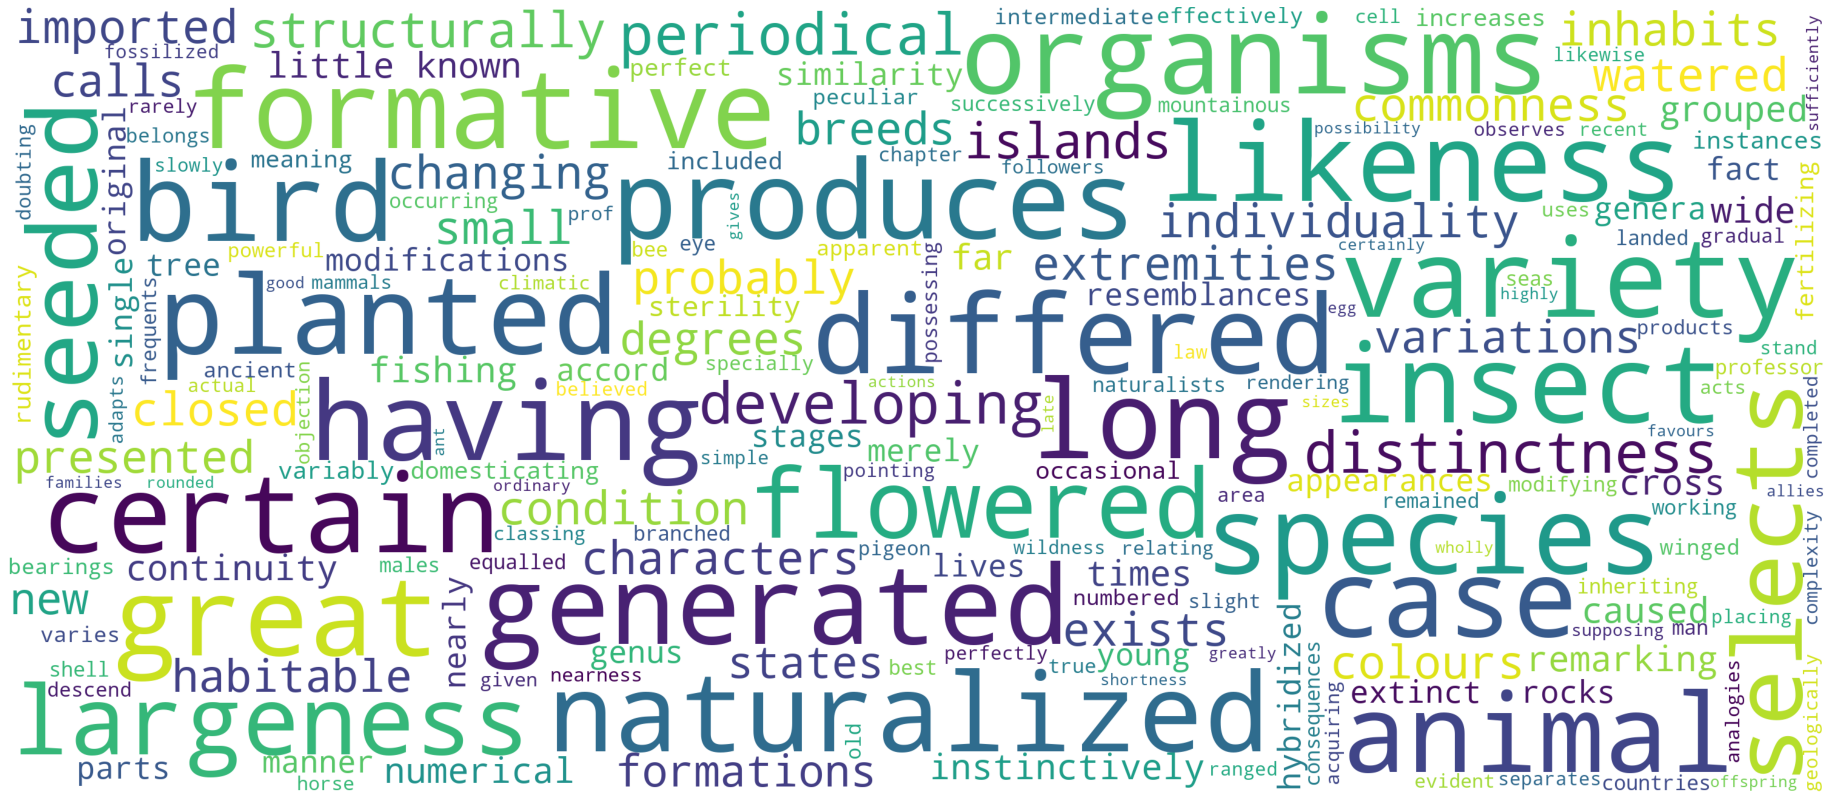

In [9]:
from wordcloud import WordCloud
wc = WordCloud(height=1300, width=3000, background_color='white', relative_scaling=0, prefer_horizontal=.95, max_font_size=int(180))
wc.generate_from_frequencies(dict(kwds))
#wc.generate_from_text(doc) # for comparison
figure(figsize=(48,14.5))
imshow(wc)
axis('off')

In [10]:
import scipy
import sklearn as sk
from sklearn import neighbors, pipeline, preprocessing, cluster

In [11]:
%tensorflow_version 2.x
import tensorflow_hub as hub


@memoize
def tfload(model_url):
  return hub.load(model_url)

In [12]:
@memoize
def emb(texts, model_url):
  return tfload(model_url)(texts)

In [13]:
lens = pars.str.len()
nice_pars = pars[(lens >= 256) & (lens <= 1024)]
len(nice_pars), len(pars)

(328, 1933)

In [15]:
%time vecs = emb(tuple(nice_pars), "https://tfhub.dev/google/universal-sentence-encoder-large/5").numpy()

CPU times: user 861 µs, sys: 182 µs, total: 1.04 ms
Wall time: 643 µs


In [17]:
D = sk.metrics.pairwise_distances(vecs, metric='cosine')
R = scipy.sparse.csgraph.minimum_spanning_tree(D).max()
G = neighbors.radius_neighbors_graph(vecs, R, metric='cosine')

@curry
def clust(g, v, n):
    pipe = pipeline.Pipeline([
        ('agg', cluster.AgglomerativeClustering(n, connectivity=g, linkage='ward', affinity='euclidean'))
    ])
    labels = pipe.fit_predict(v)
    silh = sk.metrics.silhouette_samples(v, labels, metric='cosine')
    return (silh.mean(), n, labels, silh, pipe)

R

0.693662166595459

In [18]:
core = nx.k_core(nx.Graph(G))

In [19]:
core

In [22]:
core_pars = array(nice_pars)[core.nodes]
core_vecs = vecs[core.nodes]

In [23]:
layers = nx.onion_layers(core)
layers

{2: 10,
 3: 4,
 4: 7,
 5: 10,
 8: 9,
 9: 11,
 10: 8,
 11: 10,
 13: 8,
 16: 10,
 17: 4,
 18: 9,
 20: 11,
 21: 10,
 22: 11,
 23: 10,
 24: 11,
 25: 10,
 26: 10,
 31: 7,
 35: 1,
 36: 7,
 37: 11,
 38: 11,
 39: 9,
 40: 11,
 41: 8,
 42: 10,
 43: 3,
 45: 10,
 46: 8,
 47: 10,
 49: 10,
 50: 8,
 52: 10,
 53: 10,
 55: 10,
 56: 11,
 57: 11,
 58: 10,
 59: 8,
 60: 10,
 61: 7,
 62: 5,
 64: 11,
 65: 11,
 66: 9,
 72: 3,
 74: 6,
 75: 10,
 76: 10,
 77: 10,
 80: 10,
 81: 9,
 82: 9,
 84: 9,
 86: 11,
 88: 5,
 89: 11,
 90: 10,
 91: 10,
 92: 11,
 93: 10,
 94: 9,
 95: 5,
 96: 10,
 98: 10,
 99: 6,
 101: 10,
 103: 10,
 104: 8,
 109: 10,
 110: 8,
 111: 8,
 112: 9,
 113: 6,
 114: 9,
 115: 11,
 116: 10,
 118: 4,
 120: 3,
 122: 10,
 132: 8,
 133: 10,
 134: 11,
 135: 11,
 141: 9,
 152: 11,
 154: 9,
 155: 3,
 157: 10,
 158: 2,
 160: 2,
 161: 10,
 162: 7,
 163: 6,
 166: 10,
 167: 9,
 169: 10,
 170: 6,
 171: 10,
 172: 1,
 175: 10,
 176: 10,
 177: 10,
 178: 10,
 179: 10,
 180: 11,
 181: 10,
 182: 11,
 185: 11,
 190: 10,
 

In [26]:
len(core.nodes)

168

In [27]:
core_pars

array(['It is, therefore, of the highest importance to gain a clear insight into the means of modification and coadaptation. At the commencement of my observations it seemed to me probable that a careful study of domesticated animals and of cultivated plants would offer the best chance of making out this obscure problem. Nor have I been disappointed; in this and in all other perplexing cases I have invariably found that our knowledge, imperfect though it be, of variation under domestication, afforded the best and safest clue. I may venture to express my conviction of the high value of such studies, although they have been very commonly neglected by naturalists.',
       " Causes of Variability--Effects of Habit and the use and disuse of  Parts--Correlated Variation--Inheritance--Character of Domestic  Varieties--Difficulty of distinguishing between Varieties and  Species--Origin of Domestic Varieties from one or more Species--Domestic  Pigeons, their Differences and Origin--Principles 